# Step-by-step demonstration

## Lib Imports and configurations

In [281]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading event log

In [282]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml.gz")

# Temp filter
logs_path = [x for x in logs_path if "_2" not in x and "_5" not in x and "Size1" in x and "Atomic" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  13


,0
0,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
2,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalToSequence\output\ConditionalToSequence.mxml.gz
3,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Frequency\output\Frequency.mxml.gz
4,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
5,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
6,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
7,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelToSequence\output\ParallelToSequence.mxml.gz
8,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialMove\output\SerialMove.mxml.gz
9,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialRemoval\output\SerialRemoval.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [283]:
# Loading first event log
log_path = logs_path[6]
print(log_path)
print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that remove an activity that shows where the drift happens
event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(30)

Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
Size1/ParallelRemoval
Total events:  66782
Total cases:  2999
Total activities:  28


,original_index,CaseId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id
0,0,1,1970-01-01T10:33:47.462+10:00,a,complete,1970-01-01T10:33:47.462+10:00,a,0
1,1,1,1970-01-01T11:28:08.980+10:00,e,complete,1970-01-01T11:28:08.980+10:00,e,1
2,2,1,1970-01-01T11:32:51.926+10:00,d,complete,1970-01-01T11:32:51.926+10:00,d,2
3,3,1,1970-01-01T11:39:34.303+10:00,c,complete,1970-01-01T11:39:34.303+10:00,c,3
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4
5,5,1,1970-01-01T13:29:14.845+10:00,j,complete,1970-01-01T13:29:14.845+10:00,j,5
6,6,1,64,k,complete,1970-01-01T14:25:40.585+10:00,k,6
7,7,1,1970-01-01T15:26:04.500+10:00,j,complete,1970-01-01T15:26:04.500+10:00,j,7
8,8,1,78,k,complete,1970-01-01T16:12:34.754+10:00,k,8
9,9,1,1970-01-01T17:15:34.065+10:00,j,complete,1970-01-01T17:15:34.065+10:00,j,9


## Step 1 - Instantiating class and setting event log

In [284]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

69781


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,1,START,1970-01-01T10:33:47.462+10:00,0,a,1970-01-01T10:33:47.462+10:00,0.0000,0,0
1,1,a,1970-01-01T10:33:47.462+10:00,0,e,1970-01-01T11:28:08.980+10:00,1.0000,1,1
2,1,e,1970-01-01T11:28:08.980+10:00,1,d,1970-01-01T11:32:51.926+10:00,2.0000,2,2
3,1,d,1970-01-01T11:32:51.926+10:00,2,c,1970-01-01T11:39:34.303+10:00,3.0000,3,3
4,1,c,1970-01-01T11:39:34.303+10:00,3,i,1970-01-01T12:32:42.811+10:00,4.0000,4,4
5,1,i,1970-01-01T12:32:42.811+10:00,4,j,1970-01-01T13:29:14.845+10:00,5.0000,5,5
6,1,j,1970-01-01T13:29:14.845+10:00,5,k,1970-01-01T14:25:40.585+10:00,6.0000,6,6
7,1,k,1970-01-01T14:25:40.585+10:00,6,j,1970-01-01T15:26:04.500+10:00,7.0000,7,7
8,1,j,1970-01-01T15:26:04.500+10:00,7,k,1970-01-01T16:12:34.754+10:00,8.0000,8,8
9,1,k,1970-01-01T16:12:34.754+10:00,8,j,1970-01-01T17:15:34.065+10:00,9.0000,9,9


## Step 2 - Setting Window Strategy

In [285]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)
# TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 1, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 8000},
 1: {'start': 2000, 'end': 10000},
 2: {'start': 4000, 'end': 12000},
 3: {'start': 6000, 'end': 14000},
 4: {'start': 8000, 'end': 16000},
 5: {'start': 10000, 'end': 18000},
 6: {'start': 12000, 'end': 20000},
 7: {'start': 14000, 'end': 22000},
 8: {'start': 16000, 'end': 24000},
 9: {'start': 18000, 'end': 26000},
 10: {'start': 20000, 'end': 28000},
 11: {'start': 22000, 'end': 30000},
 12: {'start': 24000, 'end': 32000},
 13: {'start': 26000, 'end': 34000},
 14: {'start': 28000, 'end': 36000}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [286]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability', 'direct_succession', 'causality', 'parallel', 'choice', 'loop'}
                                    , time_features={} 
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation() #.head(15)

frequency  percentual  probability  \
activity_from activity_to                                       
START         a                 1475      0.0211       0.4918   
              b                 1524      0.0218       0.5082   
a             c                  499      0.0072       0.3383   
              d                  501      0.0072       0.3397   
              e                  475      0.0068       0.3220   
b             f                  512      0.0073       0.3360   
              g                  522      0.0075       0.3425   
              h                  490      0.0070       0.3215   
c             d                  490      0.0070       0.3322   
              e                  489      0.0070       0.3315   
              i                  496      0.0071       0.3363   
d             c                  483      0.0069       0.3275   
              e                  511      0.0073       0.3464   
              i                  481      0.0069       0.3261   
e             c                  493      0.0071       0.3342   
              d                  484      0.0069       0.3281   
              i                  498      0.0071       0.3376   
f             g                  516      0.0074       0.3386   
              h                  497      0.0071       0.3261   
              i                  511      0.0073       0.3353   
g             f                  509      0.0073       0.3340   
              h                  537      0.0077       0.3524   
              i                  478      0.0069       0.3136   
h             f                  503      0.0072       0.3301   
              g                  486      0.0070       0.3189   
              i                  535      0.0077       0.3510   
i             j                 2999      0.0430       1.0000   
j             k                 5000      0.0717       1.0000   
k             j                 2001      0.0287       0.4002   
              l                  761      0.0109       0.1522   
              m                  734      0.0105       0.1468   
              s                 1504      0.0216       0.3008   
l             m                  761      0.0109       0.5090   
              t                  734      0.0105       0.4910   
m             l                  734      0.0105       0.4910   
              t                  761      0.0109       0.5090   
n             o                 2999      0.0430       1.0000   
o             p                 1467      0.0210       0.4892   
              q                 1532      0.0220       0.5108   
p             u                 1467      0.0210       1.0000   
q             u                 1532      0.0220       1.0000   
r             s                  930      0.0133       1.0000   
re            z                  985      0.0141       0.4923   
              z1                1016      0.0146       0.5077   
s             r                  930      0.0133       0.3821   
              t                 1504      0.0216       0.6179   
t             n                 2999      0.0430       1.0000   
u             v                 2516      0.0361       0.5047   
              w                 2469      0.0354       0.4953   
v             u                 1003      0.0144       0.3986   
              y                 1513      0.0217       0.6014   
w             x                 2469      0.0354       1.0000   
x             u                  983      0.0141       0.3981   
              y                 1486      0.0213       0.6019   
y             re                1016      0.0146       0.3388   
              z1                1983      0.0284       0.6612   
z             END               2999      0.0430       1.0000   
z1            re                 985      0.0141       0.3284   
              z                 2014      0.0289       0.6716   

                           direct_succession  causality  para

## Step 4 - Setting Change Representation

In [287]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(30)

,start,end,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,10000,0.0000,327.0000,1.4061,0.0205,17.0521,0.7689,0.0000
2,4000,12000,0.0000,427.0000,1.8488,0.0268,29.1538,0.0949,0.0296
3,6000,14000,0.0000,583.0000,2.3893,0.0365,43.5722,0.0004,0.0513
4,8000,16000,0.0000,777.0000,2.9706,0.0487,63.6859,0.0000,0.0687
5,10000,18000,0.0000,761.0000,2.8921,0.0477,59.2717,0.0000,0.0636
6,12000,20000,0.0000,699.0000,2.6856,0.0438,51.7758,0.0000,0.0579
7,14000,22000,0.0000,707.0000,2.5432,0.0443,52.2083,0.0003,0.0514
8,16000,24000,0.0000,905.0000,2.8234,0.0567,94.9563,0.0000,0.0826
9,18000,26000,0.0000,1239.0000,3.5155,0.0776,190.3541,0.0000,0.1325


## Step 5 - Setting Detection Task

In [288]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[10, 22, 31]"
1,time_series_strategy,cpd_prob_freq_delta,"[11, 21, 31]"
2,time_series_strategy,cramersv_frequency,"[10, 21, 31]"
3,threshold_strategy,cramersv_frequency,"[3, 31]"
4,threshold_strategy,gtest_frequency,"[3, 31]"


In [289]:
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]

In [290]:
# Grounding truth
log_size = event_log['CaseId'].nunique()
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()
print(ground_truth_events_indexes)

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

[23412, 46159]
ground_truth:  [8, 20, 31]


In [291]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[10, 22, 31]","[8, 20, 31]",1.0000,2.0000
1,time_series_strategy,cpd_prob_freq_delta,"[11, 21, 31]","[8, 20, 31]",1.0000,2.0000
2,time_series_strategy,cramersv_frequency,"[10, 21, 31]","[8, 20, 31]",1.0000,1.5000
3,threshold_strategy,cramersv_frequency,"[3, 31]","[8, 20, 31]",0.6700,5.0000
4,threshold_strategy,gtest_frequency,"[3, 31]","[8, 20, 31]",0.6700,5.0000


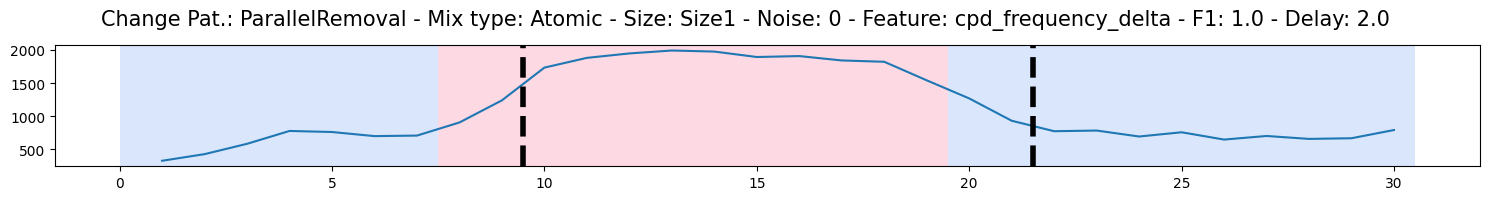

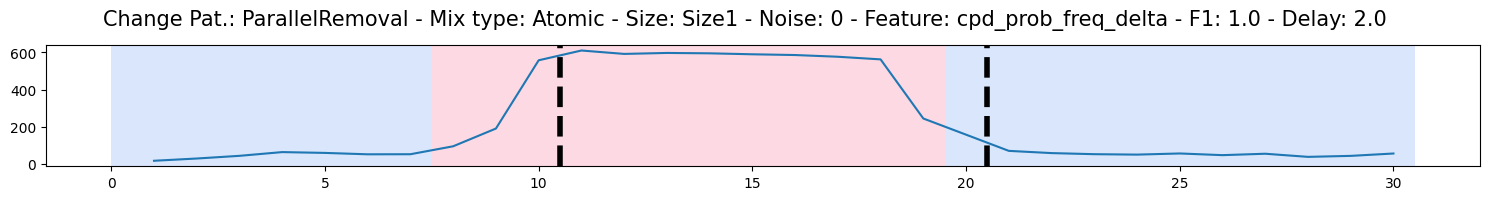

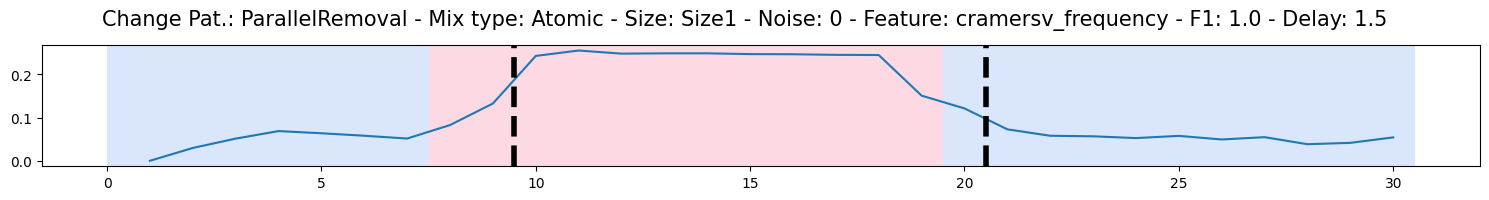

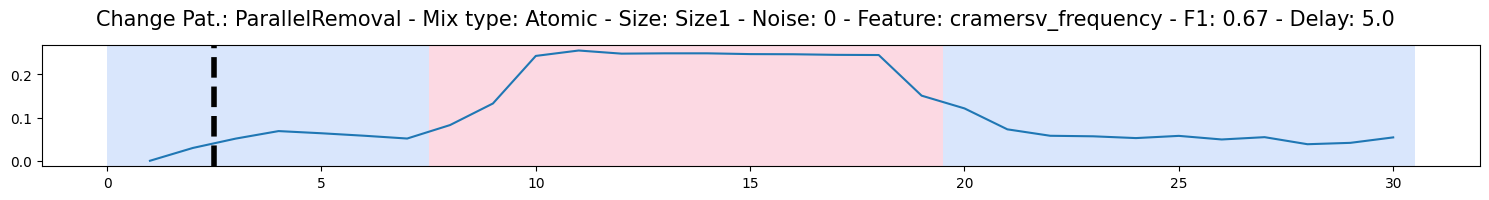

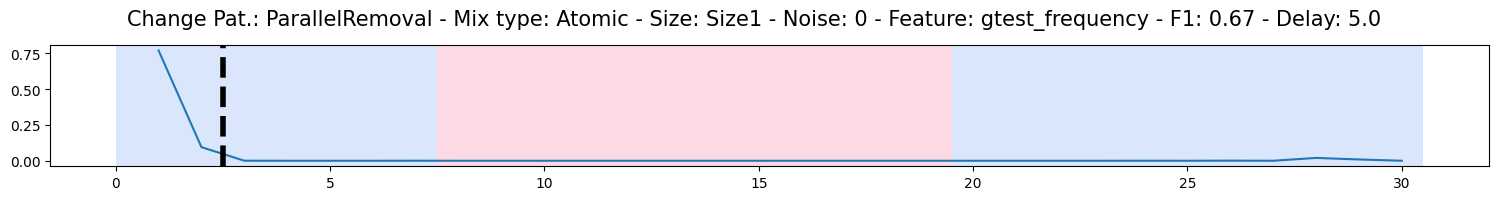

In [292]:
# Display Detection Task Results 
Noise = log_path.split("\\")[-1].split(".")[0].split("_")[-1] if log_path.split("\\")[-1].split(".")[0].split("_")[-1].isdigit() else 0

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + str(log_path.split("\\")[-3])   
                 + " - Mix type: " + str(log_path.split("\\")[-4])  
                 + " - Size: " + str(log_path.split("\\")[-5]) 
                 + " - Noise: " + str(Noise)
                 + " - Feature: " + str(result.detection_feature) 
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

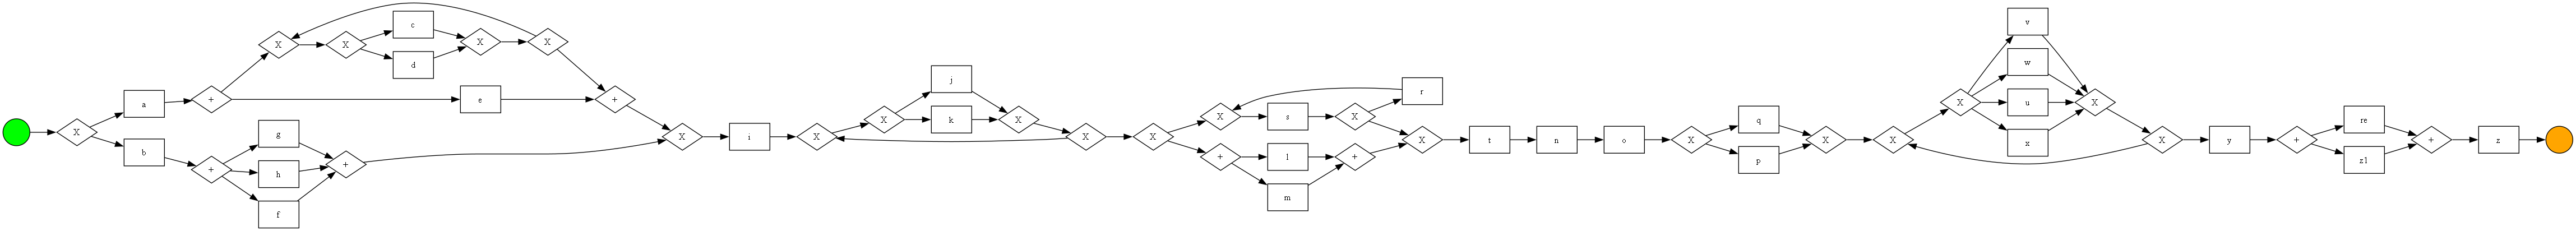

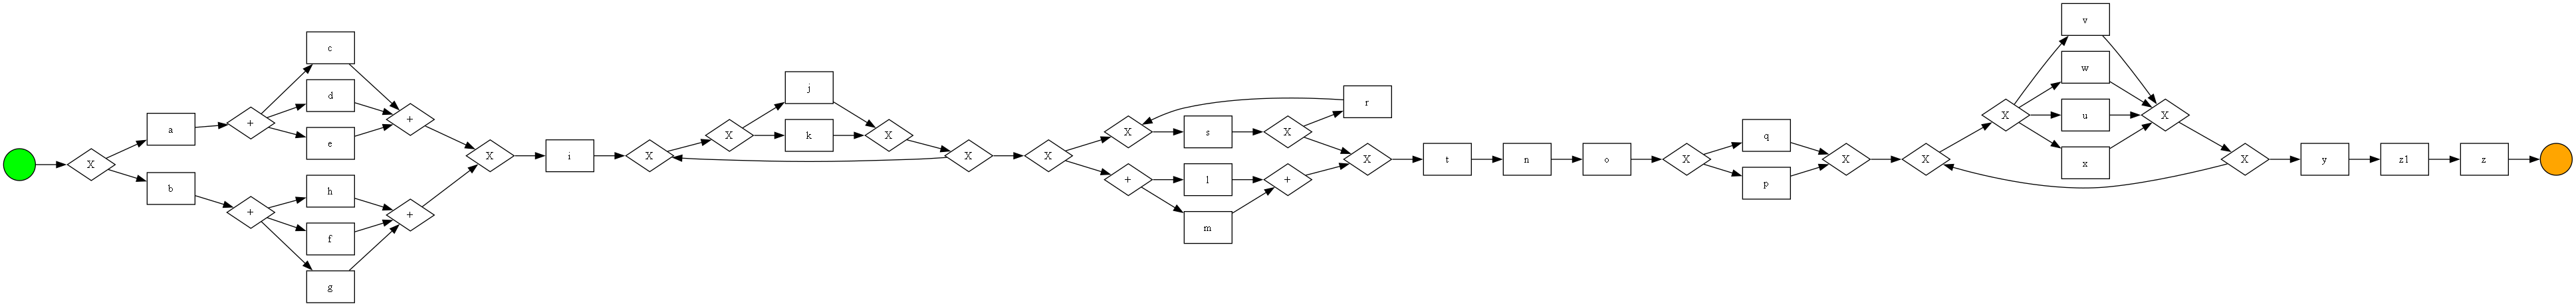

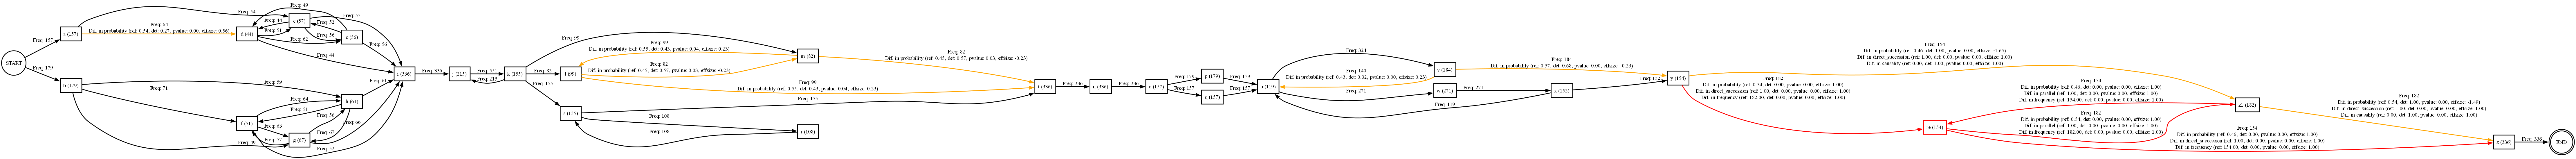

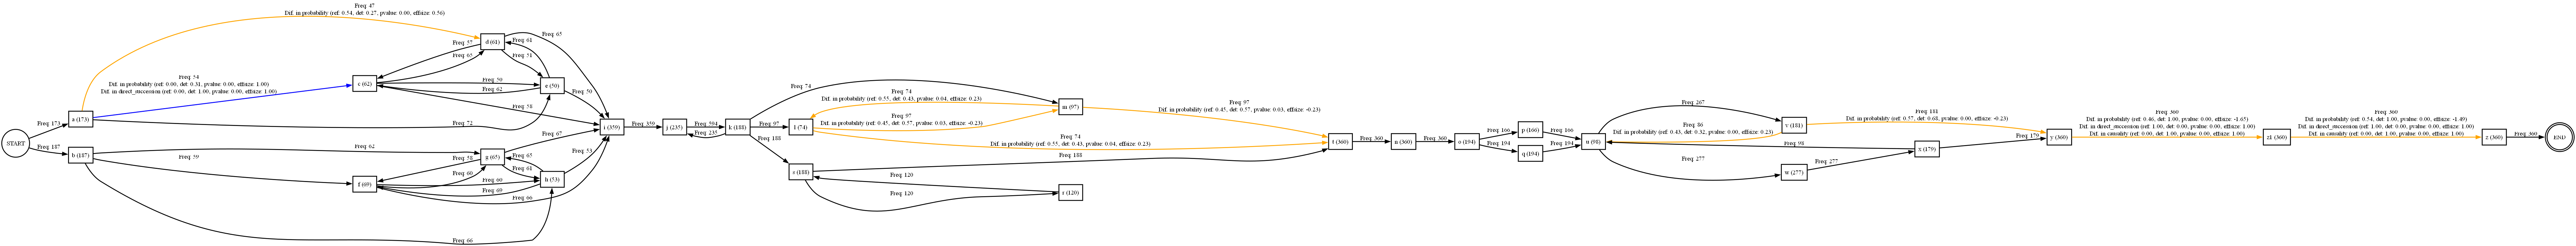

In [293]:
# Setting Localization Task
reference_window_index=0 
detection_window_index=14

TMPD_instance.set_localization_task(reference_window_index=reference_window_index, detection_window_index=detection_window_index, pvalue_threshold=0.05, effect_threshold=0.2, presence_percentage_threshold=0.01, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
significant_transition_changes, high_level_changes, reference_bpmn_text, detection_bpmn_text = TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [294]:
significant_transition_changes

,transition,feature,perspective,transition_status,activity_status,p_value,effect_size,ref_value,det_value,dif_value
0,"(a, c)",probability,control_flow,new,no change,0.0000,1.0000,0.0000,0.3121,0.3121
1,"(a, c)",direct_succession,control_flow,new,no change,0.0000,1.0000,0.0000,1.0000,1.0000
2,"(a, d)",probability,control_flow,significant difference,no change,0.0000,0.5591,0.5424,0.2717,-0.2707
3,"(l, m)",probability,control_flow,significant difference,no change,0.0333,-0.2290,0.4530,0.5673,0.1142
4,"(l, t)",probability,control_flow,significant difference,no change,0.0360,0.2290,0.5470,0.4327,-0.1142
5,"(m, l)",probability,control_flow,significant difference,no change,0.0360,0.2290,0.5470,0.4327,-0.1142
6,"(m, t)",probability,control_flow,significant difference,no change,0.0333,-0.2290,0.4530,0.5673,0.1142
7,"(re, z)",probability,control_flow,deleted,deleted(re),0.0000,1.0000,0.4583,0.0000,-0.4583
8,"(re, z)",direct_succession,control_flow,deleted,deleted(re),0.0000,1.0000,1.0000,0.0000,-1.0000
9,"(re, z)",frequency,control_flow,deleted,deleted(re),0.0000,1.0000,154.0000,0.0000,-154.0000


In [295]:
high_level_changes

{'Transitions with variations in probability': [('a', 'c'),
  ('a', 'd'),
  ('l', 'm'),
  ('l', 't'),
  ('m', 'l'),
  ('m', 't'),
  ('re', 'z'),
  ('re', 'z1'),
  ('v', 'u'),
  ('v', 'y'),
  ('y', 're'),
  ('y', 'z1'),
  ('z1', 're'),
  ('z1', 'z')],
 'Transitions with variations in direct_succession': [('a', 'c'),
  ('re', 'z'),
  ('y', 're'),
  ('y', 'z1'),
  ('z1', 'z')],
 'Transitions with variations in parallel': [('re', 'z1'), ('z1', 're')],
 'Transitions with variations in frequency': [('re', 'z'),
  ('re', 'z1'),
  ('y', 're'),
  ('z1', 're')],
 'Transitions with variations in causality': [('y', 'z1'), ('z1', 'z')],
 'New transitions added to the process': [('a', 'c')],
 'Deleted transitions from the process': [('y', 're'),
  ('z1', 're'),
  ('re', 'z1'),
  ('re', 'z')],
 'New activities added to the process': ['None'],
 'Deleted activities from the process': ['re']}

In [296]:
reference_bpmn_text, detection_bpmn_text

("Sequence( Conditional( Sequence( 'a', Parallel( Loop( Conditional( 'c', 'd' ), tau ), 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Conditional( Loop( 's', 'r' ), Parallel( 'l', 'm' ) ), 't', 'n', 'o', Conditional( 'q', 'p' ), Loop( Conditional( 'u', 'x', 'v', 'w' ), tau ), 'y', Parallel( 're', 'z1' ), 'z' )",
 "Sequence( Conditional( Sequence( 'a', Parallel( 'c', 'd', 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Conditional( Loop( 's', 'r' ), Parallel( 'l', 'm' ) ), 't', 'n', 'o', Conditional( 'q', 'p' ), Loop( Conditional( 'u', 'x', 'v', 'w' ), tau ), 'y', 'z1', 'z' )")

In [297]:
# Debug

## Getting the reference window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[reference_window_index]['start']:TMPD_instance.get_windowing_strategy()[reference_window_index]['end']])
reference_window_df = TMPD_instance.get_process_representation()
reference_window_df

frequency  percentual  probability  \
activity_from activity_to                                       
START         a                  157      0.0196       0.4673   
              b                  179      0.0224       0.5327   
a             d                   64      0.0080       0.5424   
              e                   54      0.0067       0.4576   
b             f                   71      0.0089       0.3966   
              g                   49      0.0061       0.2737   
              h                   59      0.0074       0.3296   
c             d                   49      0.0061       0.3121   
              e                   52      0.0065       0.3312   
              i                   56      0.0070       0.3567   
d             c                   62      0.0077       0.3949   
              e                   51      0.0064       0.3248   
              i                   44      0.0055       0.2803   
e             c                   56      0.0070       0.3567   
              d                   44      0.0055       0.2803   
              i                   57      0.0071       0.3631   
f             g                   63      0.0079       0.3520   
              h                   64      0.0080       0.3575   
              i                   52      0.0065       0.2905   
g             f                   57      0.0071       0.3184   
              h                   56      0.0070       0.3128   
              i                   66      0.0083       0.3687   
h             f                   51      0.0064       0.2849   
              g                   67      0.0084       0.3743   
              i                   61      0.0076       0.3408   
i             j                  336      0.0420       1.0000   
j             k                  551      0.0689       1.0000   
k             j                  215      0.0269       0.3902   
              l                   82      0.0103       0.1488   
              m                   99      0.0124       0.1797   
              s                  155      0.0194       0.2813   
l             m                   82      0.0103       0.4530   
              t                   99      0.0124       0.5470   
m             l                   99      0.0124       0.5470   
              t                   82      0.0103       0.4530   
n             o                  336      0.0420       1.0000   
o             p                  179      0.0224       0.5327   
              q                  157      0.0196       0.4673   
p             u                  179      0.0224       1.0000   
q             u                  157      0.0196       1.0000   
r             s                  108      0.0135       1.0000   
re            z                  154      0.0192       0.4583   
              z1                 182      0.0227       0.5417   
s             r                  108      0.0135       0.4106   
              t                  155      0.0194       0.5894   
t             n                  336      0.0420       1.0000   
u             v                  324      0.0405       0.5445   
              w                  271      0.0339       0.4555   
v             u                  140      0.0175       0.4321   
              y                  184      0.0230       0.5679   
w             x                  271      0.0339       1.0000   
x             u                  119      0.0149       0.4391   
              y                  152      0.0190       0.5609   
y             re                 182      0.0227       0.5417   
              z1                 154      0.0192       0.4583   
z             END                336      0.0420       1.0000   
z1            re                 154      0.0192       0.4583   
              z                  182      0.0227       0.5417   

                           direct_succession  causality  parallel  choice  \
activity_from activity_to                        

In [298]:
## Getting the detection window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[detection_window_index]['start']:TMPD_instance.get_windowing_strategy()[detection_window_index]['end']])
detection_window_df = TMPD_instance.get_process_representation()
detection_window_df

frequency  percentual  probability  \
activity_from activity_to                                       
START         a                  173      0.0216       0.4806   
              b                  187      0.0234       0.5194   
a             c                   54      0.0067       0.3121   
              d                   47      0.0059       0.2717   
              e                   72      0.0090       0.4162   
b             f                   59      0.0074       0.3155   
              g                   62      0.0077       0.3316   
              h                   66      0.0083       0.3529   
c             d                   65      0.0081       0.3757   
              e                   50      0.0063       0.2890   
              i                   58      0.0073       0.3353   
d             c                   57      0.0071       0.3295   
              e                   51      0.0064       0.2948   
              i                   65      0.0081       0.3757   
e             c                   62      0.0077       0.3584   
              d                   61      0.0076       0.3526   
              i                   50      0.0063       0.2890   
f             g                   60      0.0075       0.3226   
              h                   60      0.0075       0.3226   
              i                   66      0.0083       0.3548   
g             f                   58      0.0073       0.3118   
              h                   61      0.0076       0.3280   
              i                   67      0.0084       0.3602   
h             f                   69      0.0086       0.3690   
              g                   65      0.0081       0.3476   
              i                   53      0.0066       0.2834   
i             j                  359      0.0449       1.0000   
j             k                  594      0.0742       1.0000   
k             j                  235      0.0294       0.3956   
              l                   97      0.0121       0.1633   
              m                   74      0.0092       0.1246   
              s                  188      0.0235       0.3165   
l             m                   97      0.0121       0.5673   
              t                   74      0.0092       0.4327   
m             l                   74      0.0092       0.4327   
              t                   97      0.0121       0.5673   
n             o                  360      0.0450       1.0000   
o             p                  166      0.0208       0.4611   
              q                  194      0.0243       0.5389   
p             u                  166      0.0208       1.0000   
q             u                  194      0.0243       1.0000   
r             s                  120      0.0150       1.0000   
s             r                  120      0.0150       0.3896   
              t                  188      0.0235       0.6104   
t             n                  360      0.0450       1.0000   
u             v                  267      0.0334       0.4908   
              w                  277      0.0346       0.5092   
v             u                   86      0.0107       0.3221   
              y                  181      0.0226       0.6779   
w             x                  277      0.0346       1.0000   
x             u                   98      0.0123       0.3538   
              y                  179      0.0224       0.6462   
y             z1                 360      0.0450       1.0000   
z             END                360      0.0450       1.0000   
z1            z                  360      0.0450       1.0000   

                           direct_succession  causality  parallel  choice  \
activity_from activity_to                                                   
START         a                            0          0         0       1   
              b                            0          0         0       1   
a            

In [299]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-3]

change_activities_ground_truth = {
    'ConditionalMove': {
        'change_pattern_name': 'Conditional-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ConditionalRemoval': {
        'change_pattern_name': 'Conditional-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'ConditionalToSequence': {
        'change_pattern_name': 'Conditional-To-Sequence',
        'characterization_activities': ['p', 'q'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Frequency': {
        'change_pattern_name': 'Frequency',
        'characterization_activities': ['p', 'q', 'u', 'o'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Loop': {
        'change_pattern_name': 'Loop',
        'characterization_activities': ['k'],
        'localization_activities': ['k', 'l', 's']
    },
    'ParallelMove': {
        'change_pattern_name': 'Parallel-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ParallelRemoval': {
        'change_pattern_name': 'Parallel-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['y', 'z', 'z1']
    },
    'ParallelToSequence': {
        'change_pattern_name': 'Parallel-To-Sequence',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p']
    },
    'SerialMove': {
        'change_pattern_name': 'Serial-Move',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'SerialRemoval': {
        'change_pattern_name': 'Serial-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'Skip': {
        'change_pattern_name': 'Skip',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 't', 'o']
    },
    'Substitute': {
        'change_pattern_name': 'Replace',
        'characterization_activities': ['sub', 'z1'],
        'localization_activities': ['sub', 'z1', 'z', 'y']
    },
    'Swap': {
        'change_pattern_name': 'Swap',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p', 'u']
    } 
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['y', 'z', 'z1']

In [300]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['a', 'v', 'd', 'z', 'm', 't', 'c', 'u', 're', 'y', 'l', 'z1']


{'localization_activities_precision': 0.25,
 'localization_activities_recall': 1.0,
 'localization_activities_f1_score': 0.4}

In [301]:
# # Skip Pattern temporary test
# TMPD_instance.detection_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'e', 'd', 'c' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Parallel( 'm', 'l' ), 'r' ) ), 't', Conditional( 'n', 'tau'), 'o', 'p', Loop( Conditional( 'x', 'v', 'w', 'u' ), tau ), 'y', 'z' )"
# TMPD_instance.detection_bpmn_text

# # Conditional Removal Pattern temporary test
# TMPD_instance.reference_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'c', 'd', 'e' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Conditional( 'm', 'l' ), 'r' ) ), 't', 'n', 'o', Conditional( 'p', 'q' ), Loop( Conditional( 'w', 'u', 'x', 'v' ), tau ), 'y', Conditional( 're', 'z') )"
# TMPD_instance.reference_bpmn_text

## Step 6b - Setting Characterization Task

In [308]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-5", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml') 
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.5-pro", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
characterization_prompt, characterization_response = TMPD_instance.get_characterization_task()

ValueError: Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 1.

In [ ]:
print(characterization_prompt)

# MAIN INSTRUCTIONS

## 1. Role and Goal

- **Role**: You are an expert process mining analyst specializing in concept drift characterization.
- **Goal**: Your objective is to deeply understand and explain the transformation observed between two versions of a business process. Your primary value is not in listing raw changes, but in synthesizing them into a coherent narrative that explains the *nature*, *scope*, and *impact* of the process evolution.

## 2. Core Analytical Principles (Follow Strictly)

- **Strictly Adhere to Provided Data**: You MUST NOT infer, speculate, or comment on any perspective if no data is provided for it. If a perspective has no significant changes, state: "**No significant changes were detected for this perspective.**"
- **Analyze from the Detection Window's Perspective**: Your entire analysis must be based on the process structure as defined in the **Detection Window (the new reality)**. First, establish the new flow, then explain how it differs from the ol

In [ ]:
print(characterization_response)

Here is the expert analysis of the process concept drift.

### I. Integrated Change Characterization

The process has undergone a targeted redesign, characterized primarily by a significant structural simplification at the end of the process and the introduction of a new path at the beginning.

#### Control-Flow Perspective

The analysis, based on the new process structure in the detection window, reveals two major and two minor areas of transformation.

**1. Major Transformation: Simplification and Linearization of the Process Conclusion**

The most impactful change is the complete removal of activity `re` and the associated simplification of the process's final steps.

*   **Reference Window (Old Flow):** The process concluded with a complex sub-flow. After activity `y`, cases could proceed to either `re` or `z1`. These two activities, `re` and `z1`, were configured for parallel execution (indicated by `parallel=1` flags for `re` -> `z1` and `z1` -> `re`), creating multiple potential

## Step 6c - Setting Explanation Task

In [305]:
# TODO